In [2]:
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import os
import shutil

In [3]:
def draw_boxes(image, boxes):
    fig, ax = plt.subplots(1, figsize=(7,7))
    
    colors = {i: np.random.rand(3,) for i in range(len(boxes))}
    for i, box in enumerate(boxes):
        y, x, h, w = box[0], box[1], box[2], box[3]
        ymin, xmin, ymax, xmax = x, y, x+w, y+h
        p = Polygon(((xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)),
            fc=(colors[i][0],colors[i][1],colors[i][2],0.35), 
            ec=(colors[i][0],colors[i][1],colors[i][2],0.95), lw=3)
        ax.add_patch(p)
    ax.imshow(image, cmap=plt.cm.gist_gray)

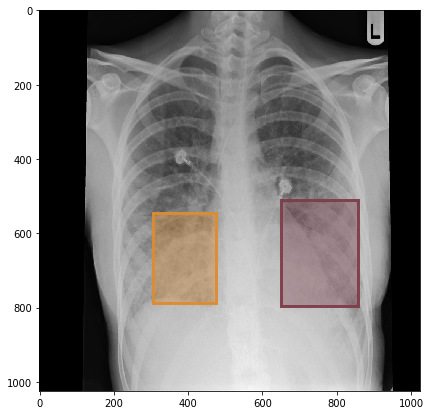

In [4]:
base = "../pneumonia"
train_info_path = base + "/stage_2_train_labels.csv"
data = pd.read_csv(train_info_path)

# get labels
idx = '00c0b293-48e7-4e16-ac76-9269ba535a62'
boxes = data[data['patientId'] == idx][['x', 'y', 'width', 'height']].values.tolist()

# get image
dcm_data = pydicom.read_file(base+'/stage_2_train_images/'+idx+'.dcm')
image = dcm_data.pixel_array

# draw image with labels
draw_boxes(image, boxes)

In [5]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [6]:
# dataset was uncompressed
base = "../pneumonia"

# The directory where we will
# store our smaller dataset
base_dir = base + "/dataset"
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training positive pictures
train_positive_dir = os.path.join(train_dir, 'positive')
os.mkdir(train_positive_dir)

# Directory with our training negative pictures
train_negative_dir = os.path.join(train_dir, 'negative')
os.mkdir(train_negative_dir)

# Directory with our validation positive pictures
validation_positive_dir = os.path.join(validation_dir, 'positive')
os.mkdir(validation_positive_dir)

# Directory with our validation negative pictures
validation_negative_dir = os.path.join(validation_dir, 'negative')
os.mkdir(validation_negative_dir)

# Directory with our validation positive pictures
test_positive_dir = os.path.join(test_dir, 'positive')
os.mkdir(test_positive_dir)

# Directory with our validation negative pictures
test_negative_dir = os.path.join(test_dir, 'negative')
os.mkdir(test_negative_dir)

In [7]:
import png

def dicom2png(file, output_folder):
    try:
        ds = pydicom.dcmread(file + ".dcm")
        shape = ds.pixel_array.shape

        # Convert to float to avoid overflow or underflow losses.
        image_2d = ds.pixel_array.astype(float)

        # Rescaling grey scale between 0-255
        image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

        # Convert to uint
        image_2d_scaled = np.uint8(image_2d_scaled)

        # Write the PNG file
        with open(output_folder +'.png' , 'wb') as png_file:
            w = png.Writer(shape[1], shape[0], greyscale=True)
            w.write(png_file, image_2d_scaled)
    except:
        print('Could not convert: ', file)

In [8]:
labels_dir = "/stage_2_train_labels.csv"
images_dir = "/stage_2_train_images"

labels = pd.read_csv(base+labels_dir)
labels = labels.drop_duplicates(["patientId"])

positive_ids = labels[labels["Target"] == 1]["patientId"].values.tolist()
train_positive_size = round(len(positive_ids) * 0.7)
validation_positive_size = round(len(positive_ids) * 0.15)

train_positive_ids = positive_ids[:train_positive_size]
validation_positive_ids = positive_ids[train_positive_size:(train_positive_size+validation_positive_size)]
test_positive_ids = positive_ids[(train_positive_size+validation_positive_size):]


negative_ids = labels[labels["Target"] == 0]["patientId"].values.tolist()[:6012]
train_negative_size = round(len(negative_ids) * 0.7)
validation_negative_size = round(len(negative_ids) * 0.15)

train_negative_ids = negative_ids[:train_negative_size]
validation_negative_ids = negative_ids[train_negative_size:(train_negative_size+validation_negative_size)]
test_negative_ids = negative_ids[(train_negative_size+validation_negative_size):]

print('total positive images:', len(positive_ids))
print('total negative images:', len(negative_ids))
print()
print('total training positive images:', len(train_positive_ids))
print('total training negative images:', len(train_negative_ids))
print()
print('total validation positive images:', len(validation_positive_ids))
print('total validation negative images:', len(validation_negative_ids))
print()
print('total test positive images:', len(test_positive_ids))
print('total test negative images:', len(test_negative_ids))

total positive images: 6012
total negative images: 6012

total training positive images: 4208
total training negative images: 4208

total validation positive images: 902
total validation negative images: 902

total test positive images: 902
total test negative images: 902


In [9]:
dataset = "/dataset"

print("Converting train positive images")
for value in train_positive_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/train/positive",value)
    dicom2png(src, dst)
    
print("Converting train negative images")
for value in train_negative_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/train/negative",value)
    dicom2png(src, dst)

print("Converting validation positive images")
for value in validation_positive_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/validation/positive",value)
    dicom2png(src, dst)

print("Converting validation negative images")
for value in validation_negative_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/validation/negative",value)
    dicom2png(src, dst)
    
print("Converting test positive images")
for value in test_positive_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/test/positive",value)
    dicom2png(src, dst)
    
print("Converting test negative images")
for value in test_negative_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/test/negative",value)
    dicom2png(src, dst)

print("Done")

Converting train positive images
Converting train negative images
Converting validation positive images
Converting validation negative images
Converting test positive images
Converting test negative images
Done


In [10]:
print('total positive images:', len(positive_ids))
print('total negative images:', len(negative_ids))
print()
print('total training positive images:', len(os.listdir(train_positive_dir)))
print('total training negative images:', len(os.listdir(train_negative_dir)))
print()
print('total validation positive images:', len(os.listdir(validation_positive_dir)))
print('total validation negative images:', len(os.listdir(validation_negative_dir)))
print()
print('total test positive images:', len(os.listdir(test_positive_dir)))
print('total test negative images:', len(os.listdir(test_negative_dir)))

total positive images: 6012
total negative images: 6012

total training positive images: 4208
total training negative images: 4208

total validation positive images: 902
total validation negative images: 902

total test positive images: 902
total test negative images: 902


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras

def create_model(input_shape, n_out):
    pretrain_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    model = Sequential()
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out))
    model.add(Activation('sigmoid'))
    return model

In [12]:
keras.backend.clear_session()

if os.path.exists('./keras.model'):
    model = load_model('./keras.model')
elif os.path.exists('./inceptionresnetv2-classificator/keras.model'):
    model = load_model('./inceptionresnetv2-classificator/keras.model')
else:
    model = create_model(
        input_shape=(299,299,3),
        n_out=1,
    )

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(0.000001), 
    metrics=['acc'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
activation_204 (Activation)  (None, 98304)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              100664320 
_________________________________________________________________
activation_205 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

epochs = 30
batch_size = 32
num_of_train_samples = len(os.listdir(train_positive_dir)) + len(os.listdir(train_negative_dir))
num_of_test_samples = len(os.listdir(validation_positive_dir)) + len(os.listdir(validation_negative_dir))

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode="binary",
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode="binary",
)

Found 8416 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [15]:
checkpointer = ModelCheckpoint(
    './keras.model', 
    verbose=2, 
    save_best_only=True,
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=num_of_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=num_of_test_samples // batch_size,
    verbose=1,
    callbacks=[checkpointer]
)

Epoch 1/30
263/263 [==============================] - 146s 555ms/step - loss: 0.7666 - acc: 0.5999 - val_loss: 0.8022 - val_acc: 0.6540

Epoch 00001: val_loss improved from inf to 0.80218, saving model to ./keras.model
Epoch 2/30
263/263 [==============================] - 127s 485ms/step - loss: 0.6595 - acc: 0.6712 - val_loss: 0.6159 - val_acc: 0.6727

Epoch 00002: val_loss improved from 0.80218 to 0.61590, saving model to ./keras.model
Epoch 3/30
263/263 [==============================] - 127s 483ms/step - loss: 0.6195 - acc: 0.6950 - val_loss: 0.6821 - val_acc: 0.6970

Epoch 00003: val_loss did not improve from 0.61590
Epoch 4/30
263/263 [==============================] - 127s 483ms/step - loss: 0.5923 - acc: 0.7121 - val_loss: 0.7107 - val_acc: 0.6845

Epoch 00004: val_loss did not improve from 0.61590
Epoch 5/30
263/263 [==============================] - 127s 483ms/step - loss: 0.5618 - acc: 0.7248 - val_loss: 0.4944 - val_acc: 0.7099

Epoch 00005: val_loss improved from 0.61590 t

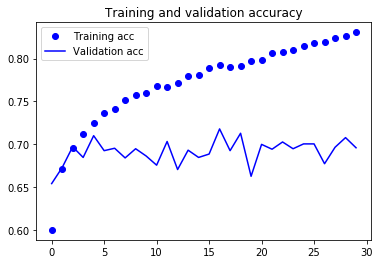

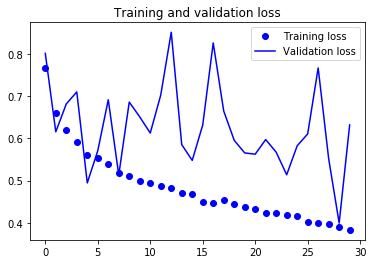

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred))
print()
print("Classification Report")
target_names = ["negative", "positive"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[527 375]
 [515 387]]

Classification Report
              precision    recall  f1-score   support

    negative       0.51      0.58      0.54       902
    positive       0.51      0.43      0.47       902

    accuracy                           0.51      1804
   macro avg       0.51      0.51      0.50      1804
weighted avg       0.51      0.51      0.50      1804

